<center>Instacart Market Basket Analysis<br>	
MSBA 327<br>
Brigite T. Crow, Brandon Pak, Prabin Nyaupane, Evan Uribe<br>
https://www.kaggle.com/c/instacart-market-basket-analysis </center>



The dataset for this competition is a relational set of files describing customers' orders over time. The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. 

For each user,between 4 and 100 of their orders is provided, with the sequence of products purchased in each order. The week and hour of day the order was placed, and a relative measure of time between orders is also provided

**File descriptions**<br>
Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

**order_products__*.csv** <br>
These files specify which products were purchased in each order.

<b>order_products__prior.csv</b> contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. 

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [35]:
path = './input/'

orders = pd.read_csv(path+'orders.csv')
order_prod_prior = pd.read_csv(path+'order_products__prior.csv') #contains prior customer orders
order_prod_train = pd.read_csv(path+'order_products__train.csv') #test users

# EDA  (Evan Uribe)

<b>products ordered by users with prior orders</b>

In [36]:
print(order_prod_prior.shape)
order_prod_prior.head(3)

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


<b>products ordered by training users</b>

In [37]:
print(order_prod_train.shape)
order_prod_train.head(3)

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


<b>product aisles</b>

In [38]:
aisles = pd.read_csv(path+'aisles.csv')
aisles.isnull().sum(axis = 0) # any missing
print(aisles.shape)
aisles.head(3)

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


<b>product departments</b>

In [39]:
departments = pd.read_csv(path+'departments.csv')
departments.isnull().sum(axis = 0)
print(departments.shape)
departments.head(3)

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery


<b>products</b>

In [40]:
products = pd.read_csv(path+'products.csv')
products.isnull().sum(axis = 0)
print(products.shape)
products.head(3)

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


<b>merged products with aisle and department</b>

In [41]:
products = pd.merge(products, departments, on='department_id')
products = pd.merge(products, aisles , on='aisle_id')
print(products.shape)
products.head()

(49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


### Missing Data/Data Cleansing

Products with missing aisle and department

In [42]:
missing = products[products['aisle'] == 'missing']
missing.head()

,product_id,product_name,aisle_id,department_id,department,aisle
42813,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
42814,72,Organic Honeycrisp Apples,100,21,missing,missing
42815,110,Uncured Turkey Bologna,100,21,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing


In [43]:
print('products with missing dept/aisle', missing.shape)
print('prior orders of products with missing dept/aisle', 
pd.merge(missing, order_prod_prior, on='product_id').shape)
print ('training orders of products with missing dept/aisle', 
       pd.merge(missing, order_prod_train, on='product_id').shape)

products with missing dept/aisle (1258, 6)
prior orders of products with missing dept/aisle (69145, 9)
training orders of products with missing dept/aisle (8251, 9)


there are over 1200 Products with ‘missing’ department and aisle.  This could be consequential during modeling.


<b>orders</b>

In [44]:
# user orders. Replace 'days_since_prior_order' from NA to 0.  
orders.isnull().sum(axis = 0)
orders= orders.fillna(value={'days_since_prior_order': 0}) # replace Nan with 0
print(orders.shape)

# inspect user 1 and 4
c1= orders['user_id']==1 
c2=orders['user_id']==4
orders[c1 | c2]

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


Each user may have n-1 prior orders where  the last order will be either a ‘test’ or 'train' order.<br>
userid = 1, is a train user and has 10 prior orders, and 1 train order.<br>
userid = 4 is a test user and has 5 prior orders with a 6th order (orderid = 329954) as a test order



In [45]:
pd.DataFrame(orders['eval_set'].value_counts())

,eval_set
prior,3214874
train,131209
test,75000


eval_set separates users across the training and test datasets. 
From the table, there are 3421083 total user orders of which 3214874 have prior orders, 131209 were used to train and 75000 for test. Of the 75000 test orders, we are to predict the products these users will order next.



In [46]:
# separate dataframes by type
oPrior = orders[orders['eval_set'] == 'prior'].sort_values('user_id',ascending=False)
oTest = orders[orders['eval_set'] == 'test'].sort_values('user_id',ascending=False)
oTrain = orders[orders['eval_set'] == 'train'].sort_values('user_id',ascending=False)

<b>user orders for product prediction</b>

In [47]:
print(oTest.shape)
oTest.sort_values('order_id',ascending=True).head()

(75000, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0


<b>merged: users prior orders with products</b>

In [48]:
oProdPrior = pd.merge(oPrior, order_prod_prior, on='order_id')

# merge prior orders with products
oProdPrior = pd.merge(oProdPrior, products, on='product_id')
print(oProdPrior.shape)
oProdPrior.head()

(32434489, 15)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2977660,206209,prior,13,1,12,7.0,24852,1,1,Banana,24,4,produce,fresh fruits
1,2266710,206209,prior,10,5,18,29.0,24852,7,0,Banana,24,4,produce,fresh fruits
2,1854736,206209,prior,11,4,10,30.0,24852,4,1,Banana,24,4,produce,fresh fruits
3,626363,206209,prior,12,1,12,18.0,24852,2,1,Banana,24,4,produce,fresh fruits
4,2892967,206202,prior,12,0,9,11.0,24852,1,1,Banana,24,4,produce,fresh fruits


<b>merge: users train orders with products</b>

In [49]:
oProdTrain = pd.merge(oTrain, order_prod_train, on='order_id')

# merge test orders with products
oProdTrain = pd.merge(oProdTrain, products, on='product_id')
print(oProdTrain.shape)
oProdTrain.head()

(1384617, 15)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,272231,206209,train,14,6,14,30.0,6846,1,1,Diet Pepsi Pack,77,7,beverages,soft drinks
1,1568820,202965,train,7,3,18,4.0,6846,2,0,Diet Pepsi Pack,77,7,beverages,soft drinks
2,2989471,202857,train,14,5,11,9.0,6846,4,1,Diet Pepsi Pack,77,7,beverages,soft drinks
3,363160,201981,train,11,1,12,30.0,6846,4,0,Diet Pepsi Pack,77,7,beverages,soft drinks
4,1360987,199906,train,11,4,14,30.0,6846,5,1,Diet Pepsi Pack,77,7,beverages,soft drinks


In [50]:
# merged priors and training
#oProdAll_m = pd.concat([oProdPrior, oProdTrain])
#oProdAll_m.shape

## Visualization

<b>top aisles ordered from</b>

In [51]:
def topAisleOrdered (dataf, count, title):
    df= dataf.groupby(['aisle_id', 'aisle'])['order_id'].count().reset_index(name='count')
    df=df.sort_values('count',ascending=False).head(50)
    df.plot(kind='barh',x='aisle',y='count', legend=False, figsize=(12,10))
    plt.ylabel('')
    plt.xlabel('Order Frequency')
    plt.title(title);

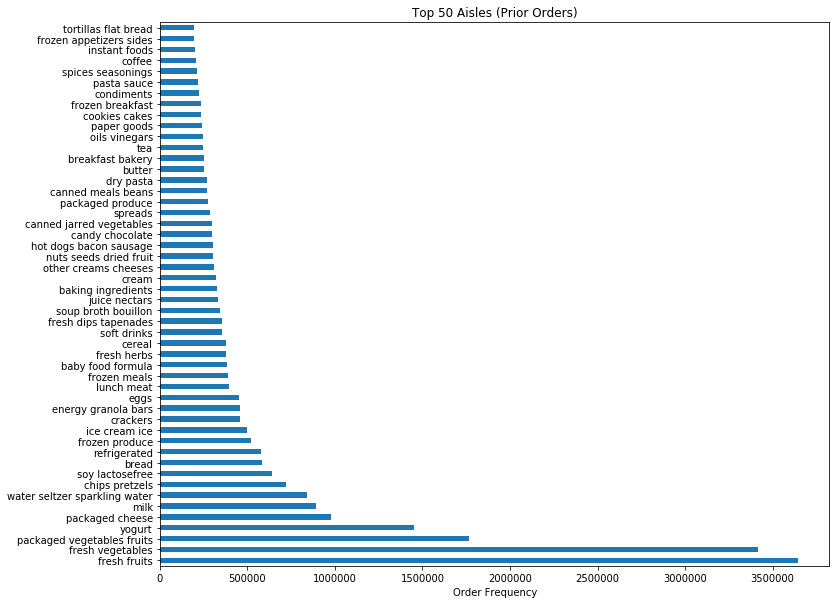

In [52]:
topAisleOrdered (oProdPrior, 50, 'Top 50 Aisles (Prior Orders)')


Top aisles ordered from include: fruits and vegetables (both fresh and packaged), and yogurt.

<b>top products ordered</b>

In [53]:
def topProductsOrdered (dataf, count, title):
    df= dataf.groupby(['product_id', 'product_name'])['order_id'].count().reset_index(name='count')
    df=df.sort_values('count',ascending=False).head(50)
    df.plot(kind='barh',x='product_name',y='count', legend=False, figsize=(12,10))
    plt.ylabel ('')
    plt.xlabel('Order Frequency')
    plt.title(title);    

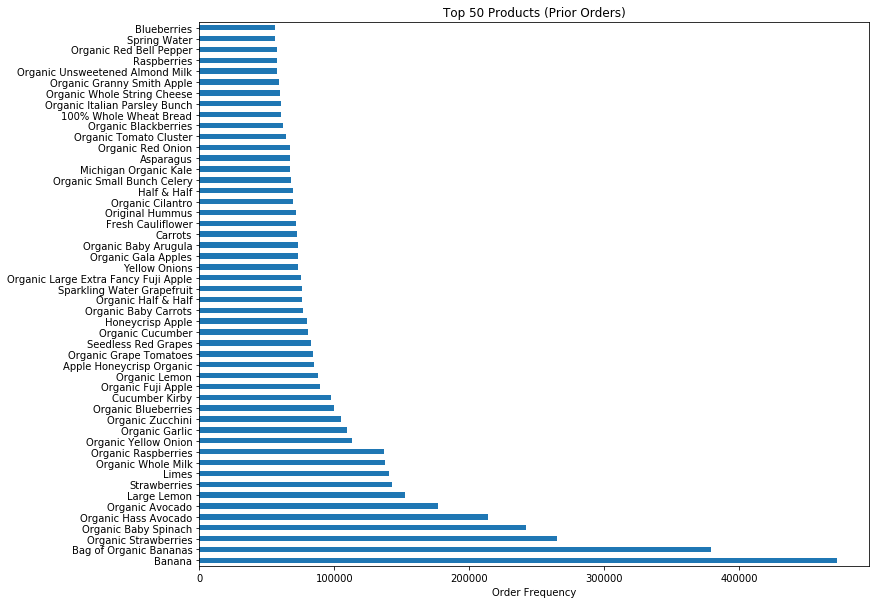

In [54]:
topProductsOrdered (oProdPrior, 50, 'Top 50 Products (Prior Orders)')


Top products ordered include: bananas (conventional and organic), organic strawberries, organic spinach, organic avocado. Most of these products are organic and healthy.

<b>days since prior order, order day of week, order hour of day</b>

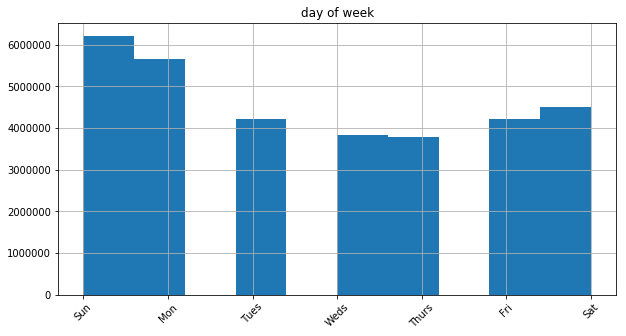

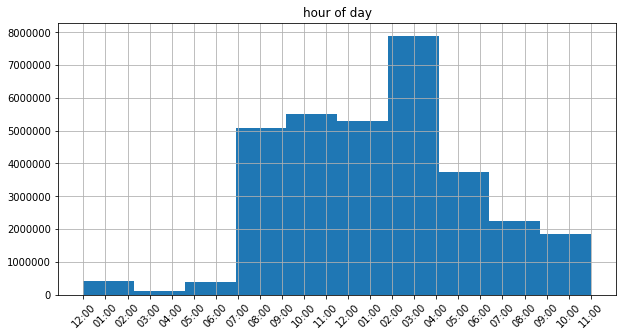

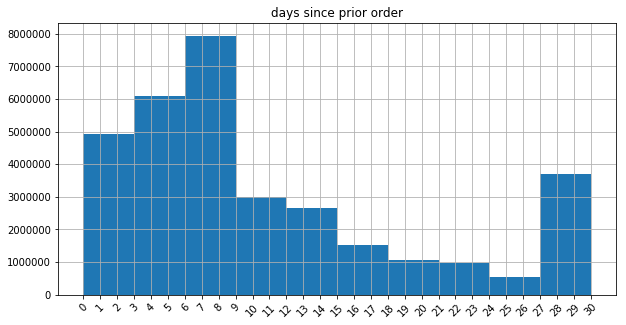

In [55]:
from datetime import datetime

def getTimeLabels():
    labels=''
    for t in range(0, 24):
        d = datetime.strptime(str(t), "%H").strftime("%I:%M")
        labels = labels + d + ' '
    return labels
    

ohist = oProdPrior[['order_dow', 'order_hour_of_day', 'days_since_prior_order']]

ohist.rename(columns = {'order_dow':'day of week', 'order_hour_of_day': 'hour of day', 
                        'days_since_prior_order': 'days since prior order'}, inplace = True) 
#ohist.describe()

for column in ohist:
    fig, ax = plt.subplots(figsize=(10, 5))
    ohist.hist(column=[column], ax=ax)
    if (column=='day of week'):
        ticks = list(range(0, 7))
        labels = "Sun Mon Tues Weds Thurs Fri Sat".split()
    elif (column=='hour of day'):
        ticks = list(range(0, 24))
        labels = getTimeLabels().split()
    else:
        ticks = list(range(0, 31))
        labels = ticks
    plt.xticks(ticks, labels,  rotation=45)

Orders are fairly evenly spread from Tuesday to Thursday with smaller decreases each day, before picking up on Friday and Saturday. Sunday has a large spike in orders with a small decline on Monday and then dropping significantly by Tuesday. Food shopping looks most popular at the start of the week.

Orders are predominantly placed between the hours of 7:00 am to 2:00 pm, with a large peak between 2:00 pm to 4:00 pm and then dropping steadily from there.

Customers seem to recorder within 9 days of their previous order, peaking between 6 to 9 days before dropping significantly for the remaining days of the month up to day 27, at which point orders dramatically increase again.

<b>Dimensionality reduction with TruncatedSVD for sparse data</b>

User products ordered previously (prior)

In [56]:
# create vocabulary for products
userPriors = oProdPrior.groupby('user_id').apply(lambda order: order['product_name'].tolist()).reset_index() #convert to list
userPriors.columns = ['user_id','products_ordered'] # set column names
userPriors['products_ordered'] = userPriors['products_ordered'].astype(str)

print(userPriors.shape)
userPriors.head()

(206209, 2)


,user_id,products_ordered
0,1,"['Bag of Organic Bananas', 'Bag of Organic Ban..."
1,2,"['Banana', 'Banana', 'Banana', 'Banana', 'Bana..."
2,3,"['Organic Peeled Whole Baby Carrots', 'Organic..."
3,4,"['Organic Large Extra Fancy Fuji Apple', 'Orga..."
4,5,"['Large Organic Omega3 Brown Eggs', 'Organic C..."


In [57]:
# text cleansing
from nltk.corpus import stopwords
import string

def clean_text(text):
    stop_words = stopwords.words('english')
    
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(' ')] # remove puncutation
    text = [word for word in text if not any(c.isdigit() for c in word)] # remove words with numbers
    text = [x for x in text if x not in stop_words] # remove stop words
    text = ' '.join(text)
    return(text)

userPriors['products_ordered'] = userPriors['products_ordered'].apply(lambda x: clean_text(x))

In [58]:
# Term Frequency – Inverse Document” Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=5,   # min docs containing this feature
                        max_df=0.7, # include words occuring in a max of 70% of all docs
                        max_features=1500,
                        #lowercase =True, 
                        #stop_words='english',
                        analyzer='word')

#Learn vocabulary and idf, return term-document matrix
X=tfidf.fit_transform(userPriors['products_ordered'])
X.shape

(206209, 1500)

In [59]:
df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
print(df.shape)
df.head()

(206209, 1500)


,aa,acai,acorn,action,actionpacs,active,added,adult,agave,aged,...,york,yotoddler,yukon,yummy,zbar,zbars,zero,zest,zesty,zucchini
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.068934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.124116,0.0,0.0,0.0
1,0.0,0.062158,0.0,0.0,0.000000,0.0,0.014961,0.0,0.00000,0.016574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.186277,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.077582,0.0,0.12329,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [60]:
# dimensionality reduction

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

#PCA does not support sparse input. See TruncatedSVD for a possible alternative
#xText = PCA().fit (X)

svd = TruncatedSVD(n_components=2)
Xtext = svd.fit_transform(X)

Xtext = pd.DataFrame(Xtext)
Xtext.columns = ['pc1','pc2']
Xtext['user_id'] = userPriors['user_id']
Xtext.head()

,pc1,pc2,user_id
0,0.143466,-0.122958,1
1,0.490021,-0.044090,2
2,0.377781,0.143325,3
3,0.254611,-0.126074,4
4,0.278697,0.170943,5


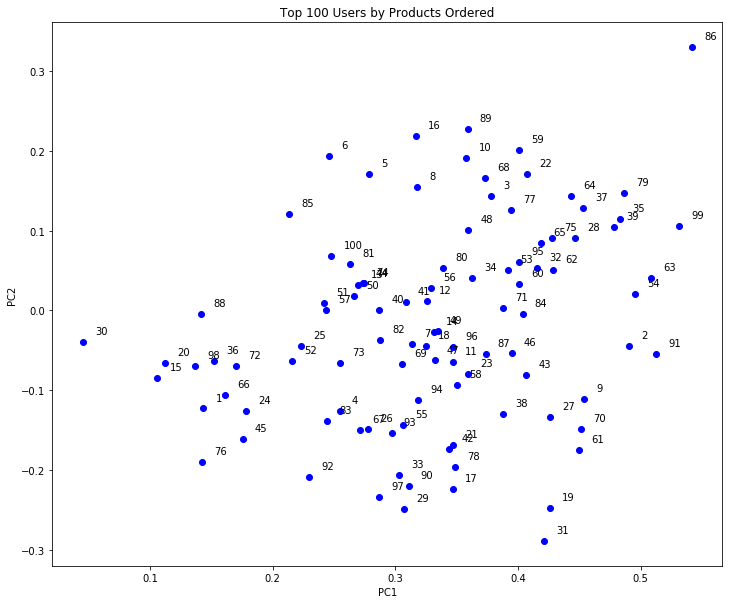

In [61]:
import matplotlib.pyplot as plt

num = 100
df = Xtext.head(num)

plt.figure(figsize=(12,10))
plt.plot(df['pc1'], df['pc2'],'bo', label=df['user_id'])
plt.title('Top '+ str(num)+ ' Users by Products Ordered')
plt.xlabel('PC1')
plt.ylabel('PC2')

#add user ids
for row in df.itertuples():
    plt.annotate(row.user_id, xy=(row.pc1, row.pc2), xytext=(row.pc1 + 0.01, row.pc2 + 0.01));

TruncatedSVD was used for dimensionality reduction, from 1500 features to 2 for EDA.   Here we see users located by the products they ordered previously (prior dataset) and can observe similarities between users.

In [62]:
#c1=userPriors['user_id'] == 8
#userPriors[c1]['products_ordered'].values

#c2=userPriors['user_id'] == 5
#userPriors[c2]['products_ordered'].values

In [63]:
# utility functions to create training and test sets
# save to csv
from pathlib import Path

def saveToCSV (fileName, df):
    fileName = Path(fileName)
    if not fileName.exists():
        df.to_csv(fileName, sep=',')

#import os
#os.remove("train.csv")

# create training set
def createTrainingSet (fileName):
    c = orders['eval_set'] == 'train' 
    c1 = orders['eval_set'] == 'prior' 
    c2 = orders['user_id'].isin(oTrain['user_id'])
    train = orders[(c|c1) & c2].sort_values('user_id',ascending=True)
    #train.head(40)
    #saveToCSV('train.csv', train)

# create test set
def createTestSet (fileName):
    c = orders['eval_set'] == 'test' 
    c1 = orders['eval_set'] == 'prior' 
    c2 = orders['user_id'].isin(oTest['user_id'])
    test = orders[(c|c1) & c2].sort_values('user_id',ascending=True)
    #test.head(40)
    #saveToCSV('test.csv', test)

In [33]:
pd.options.display.max_rows = 12

## Modeling

## Brigite T. Crow

### Y variable is "product_id" (Product feature) & Order Products Prior

In [92]:
from pandas import read_csv
import pandas as pd

# Read in the Orders "train" only of Instacart dataset
# Data subsetting done/created by Evan

orders_train = pd.read_csv(path + "train.csv")
orders_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,1187899,1,train,11,4,8,14
2,2550362,1,prior,10,4,8,30
3,3108588,1,prior,8,1,14,14
4,550135,1,prior,7,1,9,20
5,2295261,1,prior,9,1,16,0
...,...,...,...,...,...,...,...
1048569,1035648,98703,prior,7,2,14,8
1048570,2821521,98703,prior,8,0,15,5
1048571,1585815,98703,prior,9,1,16,15


### Using Order Products Prior dataset

In [93]:
# Read in the Order_Products_Prior dataset

order_products_train = pd.read_csv(path + "order_products__prior.csv")
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
...,...,...,...,...
32434483,3421083,35211,5,0
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0


### Merge "Orders train" with "Orders_Product_Prior" csv

In [94]:
# Merge "Orders train" with "Orders_Product_Prior" csv
# We want columns in the Right dataset to match with
# the left. order_products_Prior is Left, orders_train is Right
# When they merge, the "train" eval_set drops off, so the dataset is smaller???
# Removed "eval_set" column since it was creating errors (categorical not needed).

new_data_train = pd.merge(order_products_train, orders_train, on='order_id', how="left")
new_data_train = new_data_train.dropna()
del new_data_train['eval_set']
new_data_train

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
56,6,40462,1,0,22352.0,4.0,1.0,12.0,30.0
57,6,15873,2,0,22352.0,4.0,1.0,12.0,30.0
58,6,41897,3,0,22352.0,4.0,1.0,12.0,30.0
61,8,23423,1,1,3107.0,5.0,4.0,6.0,17.0
125,14,20392,1,1,18194.0,49.0,3.0,15.0,3.0
126,14,27845,2,1,18194.0,49.0,3.0,15.0,3.0
...,...,...,...,...,...,...,...,...,...
32434459,3421080,41950,4,0,52726.0,2.0,1.0,11.0,2.0
32434460,3421080,31717,5,0,52726.0,2.0,1.0,11.0,2.0
32434461,3421080,12935,6,1,52726.0,2.0,1.0,11.0,2.0


### Y variable is "product_id" (Product feature)

In [95]:
from sklearn.model_selection import train_test_split

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows. Smaller amount generates a better
# accuracy score for Support Vector Classifier
# Y variable is "user_id"

limited_new_data_train = new_data_train.head(1000)

# Preparing the data, one way
X = limited_new_data_train.drop('product_id', axis=1)  
y = limited_new_data_train['product_id']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
56,6,1,0,22352.0,4.0,1.0,12.0,30.0
57,6,2,0,22352.0,4.0,1.0,12.0,30.0
58,6,3,0,22352.0,4.0,1.0,12.0,30.0
61,8,1,1,3107.0,5.0,4.0,6.0,17.0
125,14,1,1,18194.0,49.0,3.0,15.0,3.0
126,14,2,1,18194.0,49.0,3.0,15.0,3.0
...,...,...,...,...,...,...,...,...
2800,302,9,0,54878.0,12.0,5.0,12.0,8.0
2801,302,10,1,54878.0,12.0,5.0,12.0,8.0
2802,302,11,0,54878.0,12.0,5.0,12.0,8.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification

In [96]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier

model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.0.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [97]:
from sklearn.preprocessing import StandardScaler

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [98]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 8 eigenvalues and
# corresponding eigenvectors as columns in a 8 x 8 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[0.5104202  1.46599881 0.75740597 0.86990659 1.23030281 0.96891344
 1.124839   1.0836581 ]


In [99]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [100]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [101]:
# Creating a projection matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.03341612  0.35253725]
 [ 0.07546693  0.07590491]
 [-0.53448004 -0.00334734]
 [ 0.27966036 -0.58856223]
 [-0.66935201 -0.08027609]
 [-0.03012452 -0.59718392]
 [-0.2830811   0.09270567]
 [ 0.31659876  0.38970758]]


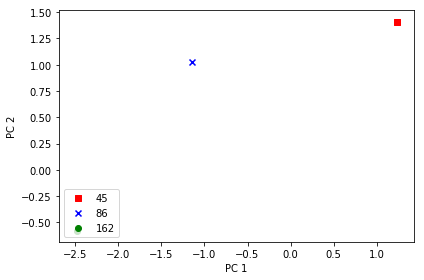

In [102]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x8 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [103]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [104]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
print(pca.explained_variance_ratio_)

[0.18298807 0.15356815]


In [105]:
# Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .XX
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.18298807 0.15356815 0.14040401]


In [106]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .93606
# 17.9% of the dataset's variance lies along the first axis,
# 14.5% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
# In order to meet the minimum acceptable variance is 60%, so
# to meet that, we have to add up PC1 to PC5 to get over 60%,
# which is 71.4%

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.18298807 0.15356815 0.14040401 0.13526375 0.12094116 0.10858298
 0.09454049]


In [107]:
# Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.99999212]


In [108]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.0.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


CART: 0.000000 (0.000000)
Random Forest: 0.015000 (0.012042)
Adaboost: 0.008000 (0.007483)


### Comparing algorithms by box plots

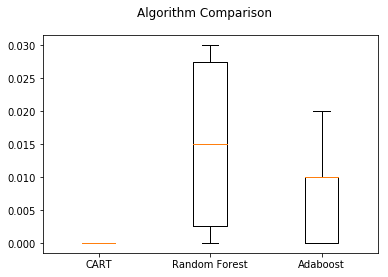

In [110]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Decision Tree Classifier (F1-score)

In [111]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Standard Decision Tree Classifier
# Do a fit method to train the system
from sklearn.tree import DecisionTreeClassifier  
dtreeC = DecisionTreeClassifier()  
dtreeC.fit(X_train, y_train)

# Make predictions using the test set
y_pred = dtreeC.predict(X_test)

# Run the classification report
from sklearn.metrics import classification_report, confusion_matrix 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

          86       0.00      0.00      0.00       0.0
         162       0.00      0.00      0.00       0.0
         196       0.00      0.00      0.00       2.0
         260       0.00      0.00      0.00       1.0
         397       0.00      0.00      0.00       0.0
         651       0.00      0.00      0.00       1.0
         812       0.00      0.00      0.00       1.0
         872       0.00      0.00      0.00       0.0
        1025       0.00      0.00      0.00       0.0
        1158       0.00      0.00      0.00       0.0
        1181       0.00      0.00      0.00       1.0
        1263       0.00      0.00      0.00       1.0
        1376       0.00      0.00      0.00       1.0
        1408       0.00      0.00      0.00       1.0
        1463       0.00      0.00      0.00       2.0
        1582   

### Y variable is "product_id" (Product feature) & Order Products Train

In [112]:
from pandas import read_csv
import pandas as pd

# Read in the Orders "train" only of Instacart dataset
# Data subsetting done/created by Evan

orders_train = pd.read_csv(path + "train.csv", index_col=0)
orders_train

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0
1187899,1,train,11,4,8,14
2550362,1,prior,10,4,8,30
3108588,1,prior,8,1,14,14
550135,1,prior,7,1,9,20
2295261,1,prior,9,1,16,0
...,...,...,...,...,...,...
1035648,98703,prior,7,2,14,8
2821521,98703,prior,8,0,15,5


In [113]:
# Read in the Order_Products_Train dataset

order_products_train = pd.read_csv(path + "order_products__train.csv")
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
...,...,...,...,...
1384611,3421063,13565,2,1
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1


In [114]:
# Merge "Orders train" with "Orders_Product_Train" csv
# We want columns in the Right dataset to match with
# the left. order_products_train is Left, orders_train is Right
# When they merge, the "train" eval_set drops off, so the dataset is smaller
# Removed "eval_set" column since it was creating errors (categorical not needed).

new_data_train = pd.merge(order_products_train, orders_train, on='order_id', how="left")
new_data_train = new_data_train.dropna()
del new_data_train['eval_set']
new_data_train

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,39612,1,0,79431.0,23.0,6.0,18.0,30.0
9,36,19660,2,1,79431.0,23.0,6.0,18.0,30.0
10,36,49235,3,0,79431.0,23.0,6.0,18.0,30.0
11,36,43086,4,1,79431.0,23.0,6.0,18.0,30.0
12,36,46620,5,1,79431.0,23.0,6.0,18.0,30.0
13,36,34497,6,1,79431.0,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...,...
1384556,3420996,1891,11,0,15818.0,16.0,1.0,9.0,7.0
1384597,3421056,5750,1,1,83898.0,13.0,2.0,20.0,11.0
1384598,3421056,9340,2,1,83898.0,13.0,2.0,20.0,11.0


In [115]:
from sklearn.model_selection import train_test_split

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows, but 0.0% accuracy score based on
# "product_id" and 1,000 to 3,000 rows for 
# Support Vector Classifier
# Y variable is "product_id"
limited_new_data_train = new_data_train.head(3000)

# Preparing the data, one way
X = limited_new_data_train.drop('product_id', axis=1)  
y = limited_new_data_train['product_id']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,1,0,79431.0,23.0,6.0,18.0,30.0
9,36,2,1,79431.0,23.0,6.0,18.0,30.0
10,36,3,0,79431.0,23.0,6.0,18.0,30.0
11,36,4,1,79431.0,23.0,6.0,18.0,30.0
12,36,5,1,79431.0,23.0,6.0,18.0,30.0
13,36,6,1,79431.0,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...
6222,15213,1,0,923.0,13.0,6.0,16.0,30.0
6223,15213,2,0,923.0,13.0,6.0,16.0,30.0
6224,15213,3,1,923.0,13.0,6.0,16.0,30.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification

In [140]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier
model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.0.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [141]:
from sklearn.preprocessing import StandardScaler

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [142]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 8 eigenvalues and
# corresponding eigenvectors as columns in a 8 x 8 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.60743385 0.56581583 0.69843382 0.79811037 0.91135283 1.2120501
 1.12084517 1.08976936]


In [143]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [144]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [145]:

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.01267085  0.34322998]
 [-0.04035326 -0.44892497]
 [-0.46085772  0.19374375]
 [-0.15437532 -0.50582414]
 [-0.62704002 -0.01318433]
 [-0.0573849  -0.16132292]
 [ 0.24074286  0.53711862]
 [ 0.55458106 -0.26938732]]


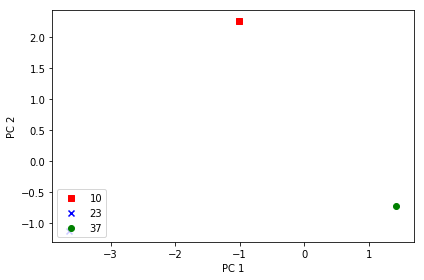

In [146]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x13 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [147]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [148]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
# PC1 and PC2 add up to .3522

print(pca.explained_variance_ratio_)

[0.20083355 0.15143412]


In [149]:
# Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .4922

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.20083355 0.15143412 0.14003893]


In [150]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .9292
# 20% of the dataset's variance lies along the first axis,
# 15.1% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
# In order to meet the minimum acceptable variance is 60%, so
# to meet that, we have to add up PC1 to PC4 to get 63%.

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.20083355 0.15143412 0.14003893 0.1361563  0.11386486 0.09971629
 0.08726265]


In [151]:
# Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.97801664]


In [152]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
# Unfortunately 0.0 accuracy as well, but PC1 to PC4 add up to .63

model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.0.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.000667 (0.001333)
Random Forest: 0.011667 (0.006368)
Adaboost: 0.008333 (0.006708)


### Comparing algorithms by box plots

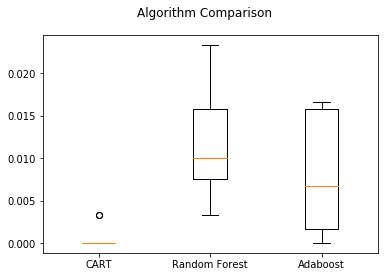

In [154]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Decision Tree Classifier (F1-score)

In [155]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Random Forest Classifier
# Do a fit method to train the system
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
random_forest.fit(X_train, y_train)

# Make predictions using the test set
y_pred = random_forest.predict(X_test)

# Run the classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
         130       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         162       0.00      0.00      0.00         1
         199       0.00      0.00      0.00         1
         206       0.00      0.00      0.00         1
         260       0.00      0.00      0.00         1
         283       0.00      0.00      0.00         2
         329       0.00      0.00      0.00         1
         365       0.00      0.00      0.00         1
         432       0.00      0.00      0.00         1
         459       0.00      0.00      0.00         1
         486       0.00      0.00      0.00         1
         743       0.00      0.00      0.00         1
         781       0.00      0.00      0.00         1
         863   

### Y variable is "order_hour_of_day" (Time feature) & Order Products Prior

In [164]:
# Read in the Orders "train" only of Instacart dataset
# Data subsetting done/created by Evan

orders_train = pd.read_csv(path + "train.csv")
orders_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,1187899,1,train,11,4,8,14
2,2550362,1,prior,10,4,8,30
3,3108588,1,prior,8,1,14,14
4,550135,1,prior,7,1,9,20
5,2295261,1,prior,9,1,16,0
...,...,...,...,...,...,...,...
1048569,1035648,98703,prior,7,2,14,8
1048570,2821521,98703,prior,8,0,15,5
1048571,1585815,98703,prior,9,1,16,15


### Using Order Products Prior dataset

In [165]:
# Read in the Order_Products_Prior dataset

order_products_prior = pd.read_csv(path + "order_products__prior.csv")
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
...,...,...,...,...
32434483,3421083,35211,5,0
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0


### Merge "Orders train" with "Orders_Product_Prior" csv

In [166]:
# Merge "Orders train" with "Orders_Product_Prior" csv
# We want columns in the Right dataset to match with
# the left. order_products_Prior is Left, orders_train is Right
# When they merge, the "train" eval_set drops off, so the dataset is smaller???
# Removed "eval_set" column since it was creating errors (categorical not needed).

new_data_prior = pd.merge(order_products_prior, orders_train, on='order_id', how="left")
new_data_prior = new_data_train.dropna()
del new_data_prior['eval_set']
new_data_prior

KeyError: 'eval_set'

### Y variable is "user_id" (Users feature)

In [167]:

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows. Smaller amount generates a better
# accuracy score for Support Vector Classifier
# Y variable is "user_id"

limited_new_data_prior = new_data_prior.head(1000)

# Preparing the data, one way
X = limited_new_data_prior.drop('order_hour_of_day', axis=1)  
y = limited_new_data_prior['order_hour_of_day']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,days_since_prior_order
8,36,39612,1,0,79431.0,23.0,6.0,30.0
9,36,19660,2,1,79431.0,23.0,6.0,30.0
10,36,49235,3,0,79431.0,23.0,6.0,30.0
11,36,43086,4,1,79431.0,23.0,6.0,30.0
12,36,46620,5,1,79431.0,23.0,6.0,30.0
13,36,34497,6,1,79431.0,23.0,6.0,30.0
...,...,...,...,...,...,...,...,...
2365,5743,12951,7,1,1173.0,56.0,6.0,8.0
2366,5743,45210,8,1,1173.0,56.0,6.0,8.0
2367,5743,27966,9,0,1173.0,56.0,6.0,8.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification)

In [168]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier

model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.31.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [169]:
from sklearn.preprocessing import StandardScaler

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [171]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 13 eigenvalues and
# corresponding eigenvectors as columns in a 13 x 13 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.73785974 0.39129958 1.26970983 0.72366539 0.80783349 0.92489454
 1.03351482 1.12266755]


In [172]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [173]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [174]:
 Creating a projection matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

SyntaxError: invalid syntax (<ipython-input-174-7e0044aa61c4>, line 1)

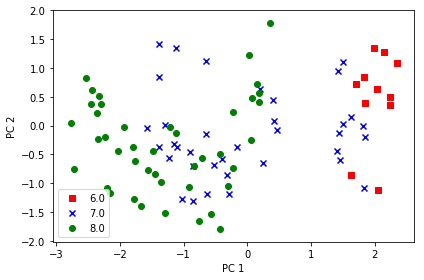

In [175]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x13 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire 124 x 13 dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [176]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [177]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
print(pca.explained_variance_ratio_)

[0.21692213 0.15848699]


In [178]:
# Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .476908
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21692213 0.15848699 0.14013297]


In [179]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .93412
# 17.9% of the dataset's variance lies along the first axis,
# 14.5% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
# To meet the minimum acceptable variance of 60%,
# we had to add up PC1 to PC4 to get to .6021

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21692213 0.15848699 0.14013297 0.1290048  0.11544666 0.10083493
 0.09032895]


In [181]:
#Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.7950454  0.20206665]


In [182]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.68.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost

In [183]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.261000 (0.142158)
Random Forest: 0.153000 (0.127519)
Adaboost: 0.100000 (0.107981)


### Comparing algorithms by box plots

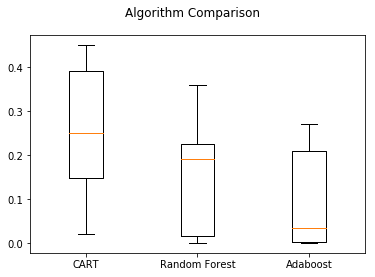

In [184]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Decision Tree Classifier (F1-score)

In [185]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Standard Decision Tree Classifier
# Do a fit method to train the system
from sklearn.tree import DecisionTreeClassifier  
dtreeC = DecisionTreeClassifier()  
dtreeC.fit(X_train, y_train)

# Make predictions using the test set
y_pred = dtreeC.predict(X_test)

# Run the classification report
from sklearn.metrics import classification_report, confusion_matrix 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1 26  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 51  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  8]]
              precision    recall  f1-score   support

         6.0       1.00      1.00      1.00         4
         7.0       1.00      1.00      1.00        13
         8.0       1

### Y variable is "order_hour_of_day" (Time feature) & Order Products Train

In [187]:
from pandas import read_csv
import pandas as pd

# Read in the Orders "train" only of Instacart dataset
# Data subsetting done/created by Evan

orders_train = pd.read_csv(path + "train.csv")
orders_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,1187899,1,train,11,4,8,14
2,2550362,1,prior,10,4,8,30
3,3108588,1,prior,8,1,14,14
4,550135,1,prior,7,1,9,20
5,2295261,1,prior,9,1,16,0
...,...,...,...,...,...,...,...
1048569,1035648,98703,prior,7,2,14,8
1048570,2821521,98703,prior,8,0,15,5
1048571,1585815,98703,prior,9,1,16,15


In [191]:
order_products_train = pd.read_csv(path + "order_products__train.csv")
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
...,...,...,...,...
1384611,3421063,13565,2,1
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1


### Merge "Orders train" with "Orders_Product_Train" csv

In [192]:
# Merge "Orders train" with "Orders_Product_Train" csv
# We want columns in the Right dataset to match with
# the left. order_products_train is Left, orders_train is Right
# When they merge, the "train" eval_set drops off, so the dataset is smaller
# Removed "eval_set" column since it was creating errors (categorical not needed).

new_data_train = pd.merge(order_products_train, orders_train, on='order_id', how="left")
new_data_train = new_data_train.dropna()
del new_data_train['eval_set']
new_data_train

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,39612,1,0,79431.0,23.0,6.0,18.0,30.0
9,36,19660,2,1,79431.0,23.0,6.0,18.0,30.0
10,36,49235,3,0,79431.0,23.0,6.0,18.0,30.0
11,36,43086,4,1,79431.0,23.0,6.0,18.0,30.0
12,36,46620,5,1,79431.0,23.0,6.0,18.0,30.0
13,36,34497,6,1,79431.0,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...,...
1384556,3420996,1891,11,0,15818.0,16.0,1.0,9.0,7.0
1384597,3421056,5750,1,1,83898.0,13.0,2.0,20.0,11.0
1384598,3421056,9340,2,1,83898.0,13.0,2.0,20.0,11.0


### Y variable is "order_hour_of_day" (Time feature)

In [193]:
from sklearn.model_selection import train_test_split

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows. Smaller amount generates a better
# accuracy score for Support Vector Classifier
# Y variable is "user_id"

limited_new_data_train = new_data_train.head(1000)

# Preparing the data, one way
X = limited_new_data_train.drop('order_hour_of_day', axis=1)  
y = limited_new_data_train['order_hour_of_day']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,days_since_prior_order
8,36,39612,1,0,79431.0,23.0,6.0,30.0
9,36,19660,2,1,79431.0,23.0,6.0,30.0
10,36,49235,3,0,79431.0,23.0,6.0,30.0
11,36,43086,4,1,79431.0,23.0,6.0,30.0
12,36,46620,5,1,79431.0,23.0,6.0,30.0
13,36,34497,6,1,79431.0,23.0,6.0,30.0
...,...,...,...,...,...,...,...,...
2365,5743,12951,7,1,1173.0,56.0,6.0,8.0
2366,5743,45210,8,1,1173.0,56.0,6.0,8.0
2367,5743,27966,9,0,1173.0,56.0,6.0,8.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification

In [194]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier

model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.31.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [195]:

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [196]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 13 eigenvalues and
# corresponding eigenvectors as columns in a 13 x 13 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.73785974 0.39129958 1.26970983 0.72366539 0.80783349 0.92489454
 1.03351482 1.12266755]


In [197]:
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [198]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [199]:
# Creating a projection matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.11156969  0.5887106 ]
 [-0.03110063 -0.24798995]
 [ 0.05865581 -0.60065483]
 [-0.31924685  0.11634586]
 [-0.29326957 -0.08072115]
 [-0.61230122 -0.25821297]
 [-0.23509003  0.33967282]
 [ 0.60418437 -0.17038414]]


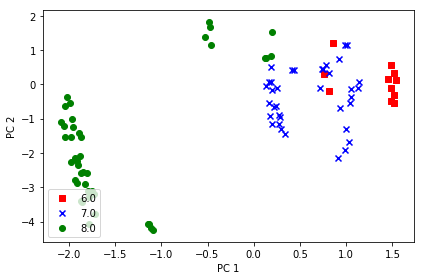

In [200]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x13 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire 124 x 13 dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


In [201]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [202]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
print(pca.explained_variance_ratio_)

[0.21692213 0.15848699]


In [203]:
# Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .5153
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21692213 0.15848699 0.14013297]


In [204]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .95115
# 21.6% of the dataset's variance lies along the first axis,
# 15.8% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
# In order to meet the minimum acceptable variance of 60%,
# we had to add up PC1 to PC4 to get to .6445.

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21692213 0.15848699 0.14013297 0.1290048  0.11544666 0.10083493
 0.09032895]


In [205]:
# Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.7950454  0.20206665]


In [206]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.68.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost try again

In [207]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


CART: 0.270000 (0.149867)
Random Forest: 0.153000 (0.127519)
Adaboost: 0.100000 (0.107981)


### Comparing algorithms by box plots

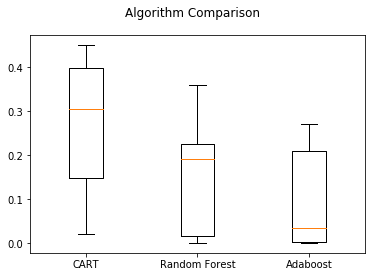

In [208]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Adaboost Classifier (F1-score

In [209]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Adaboost Classifier on Standared Decision Tree Classifier
# Do a fit method to train the system
Adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)  
Adaboost.fit(X_train, y_train)

# Make predictions using the test set
y_pred = Adaboost.predict(X_test)

# Run the classification report
# Keep output to show that this is not a good classifier
# on Time feature. Decision Tree is better.

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0 11  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  2  0  0 18  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0 23  0  2  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0 10  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  6  0  9  4  0  1  0  0  0  0]
 [ 0  0  0  0  3  0  2  1  1  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  1  0 16  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  6  3  2  0 12  0  2  3  0  0  0]
 [ 0  0  0  0  8  0  2  0  0  0 39  3  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  4  4 11  0  0  0]
 [ 0  6  0  3  0  0  0  0  5  0 10  0  3  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1  0  0  0  3  0  0  4  0  0  1]]
              precision    recall  f1-score   support

         6.0       0.00      0.00      0.00         4
         7.0       0.65      0.85      0.73        13
         8.0       0

### Y variable is "user_id" (Users feature) & Order Products Prior

In [211]:
from pandas import read_csv
import pandas as pd

# Read in the Orders "train" only of Instacart dataset
# Data subsetting done/created by Evan

orders_train = pd.read_csv(path+"train.csv")
orders_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,1187899,1,train,11,4,8,14
2,2550362,1,prior,10,4,8,30
3,3108588,1,prior,8,1,14,14
4,550135,1,prior,7,1,9,20
5,2295261,1,prior,9,1,16,0
...,...,...,...,...,...,...,...
1048569,1035648,98703,prior,7,2,14,8
1048570,2821521,98703,prior,8,0,15,5
1048571,1585815,98703,prior,9,1,16,15


In [212]:
# Read in the Order_Products_Prior dataset

order_products_prior = pd.read_csv(path+"order_products__prior.csv")
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
...,...,...,...,...
32434483,3421083,35211,5,0
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0


### Merge "Orders train" with "Orders_Product_Prior" csv

In [215]:
# Merge "Orders train" with "Orders_Product_Prior" csv
# We want columns in the Right dataset to match with
# the left. order_products_Prior is Left, orders_train is Right
# When they merge, the "train" eval_set drops off, so the dataset is smaller???
# Removed "eval_set" column since it was creating errors (categorical not needed).

new_data_prior = pd.merge(order_products_train, orders_train, on='order_id', how="left")
new_data_prior = new_data_train.dropna()
#del new_data_prior['eval_set']
new_data_prior

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,39612,1,0,79431.0,23.0,6.0,18.0,30.0
9,36,19660,2,1,79431.0,23.0,6.0,18.0,30.0
10,36,49235,3,0,79431.0,23.0,6.0,18.0,30.0
11,36,43086,4,1,79431.0,23.0,6.0,18.0,30.0
12,36,46620,5,1,79431.0,23.0,6.0,18.0,30.0
13,36,34497,6,1,79431.0,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...,...
1384556,3420996,1891,11,0,15818.0,16.0,1.0,9.0,7.0
1384597,3421056,5750,1,1,83898.0,13.0,2.0,20.0,11.0
1384598,3421056,9340,2,1,83898.0,13.0,2.0,20.0,11.0


### Y variable is "user_id" (Users feature)

In [216]:
from sklearn.model_selection import train_test_split

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows. Smaller amount generates a better
# accuracy score for Support Vector Classifier
# Y variable is "user_id"

limited_new_data_prior = new_data_prior.head(1000)

# Preparing the data, one way
X = limited_new_data_prior.drop('user_id', axis=1)  
y = limited_new_data_prior['user_id']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,39612,1,0,23.0,6.0,18.0,30.0
9,36,19660,2,1,23.0,6.0,18.0,30.0
10,36,49235,3,0,23.0,6.0,18.0,30.0
11,36,43086,4,1,23.0,6.0,18.0,30.0
12,36,46620,5,1,23.0,6.0,18.0,30.0
13,36,34497,6,1,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...
2365,5743,12951,7,1,56.0,6.0,16.0,8.0
2366,5743,45210,8,1,56.0,6.0,16.0,8.0
2367,5743,27966,9,0,56.0,6.0,16.0,8.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification)

In [217]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier

model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.08.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [218]:
from sklearn.preprocessing import StandardScaler

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [219]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 13 eigenvalues and
# corresponding eigenvectors as columns in a 13 x 13 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.7296743  1.50477644 0.38424393 0.66614151 0.86208118 0.77625687
 1.05227126 1.03599942]


In [220]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [221]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [222]:
# Creating a projection matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.26324781  0.38587401]
 [ 0.04343725 -0.08007274]
 [ 0.08079979 -0.4654556 ]
 [ 0.33336836  0.20623562]
 [ 0.66065521  0.00773688]
 [ 0.06553055  0.43953102]
 [-0.34392186  0.47671946]
 [-0.5021045  -0.40620036]]


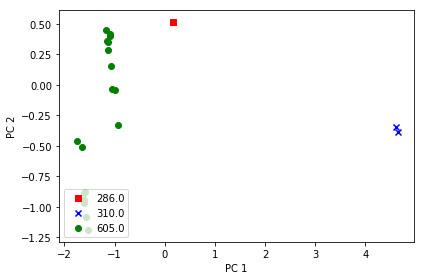

In [224]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x13 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire 124 x 13 dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [225]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [226]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
print(pca.explained_variance_ratio_)

[0.21590042 0.18782835]


In [227]:
# Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .XX
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21590042 0.18782835 0.131346  ]


In [228]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .XX
# 17.9% of the dataset's variance lies along the first axis,
# 14.5% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21590042 0.18782835 0.131346   0.12931493 0.1076062  0.09689349
 0.08314873]


In [229]:
# Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.98592117]


In [230]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.81.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost

In [231]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


CART: 0.160000 (0.132514)
Random Forest: 0.047000 (0.074169)
Adaboost: 0.160000 (0.129306)


### Comparing algorithms by box plots

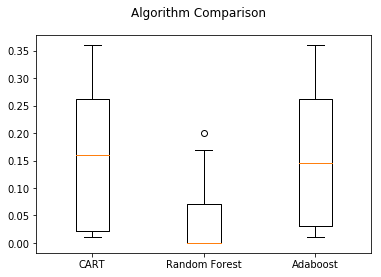

In [232]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Decision Tree Classifier (F1-score)

In [233]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Standard Decision Tree Classifier
# Do a fit method to train the system
from sklearn.tree import DecisionTreeClassifier  
dtreeC = DecisionTreeClassifier()  
dtreeC.fit(X_train, y_train)

# Make predictions using the test set
y_pred = dtreeC.predict(X_test)

# Run the classification report
from sklearn.metrics import classification_report, confusion_matrix 
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 6]]
              precision    recall  f1-score   support

       286.0       0.00      0.00      0.00         1
       310.0       1.00      1.00      1.00         2
       605.0       1.00      1.00      1.00         4
       816.0       1.00      1.00      1.00        14
      1173.0       1.00      1.00      1.00         7
      2156.0       1.00      1.00      1.00         6
      2454.0       1.00      1.00      1.00         4
      5403.0       1.00      1.00      1.00         2
      6990.0       1.00      1.00      1.00         2
      7172.0       1.00      1.00      1.00         2
      7258.0       1.00      1.00      1.00         2
      7691.0       1.00      1.00      1.00         8
     12762.0       1.00      1.00      1.00         5
     14499.0       1.00      1.00      1.00         7
     16111.0       1.00      1.00      1.00         1
     17227.0   

### Y variable is "user_id" (Users feature) and Order Products Train

### Y variable is "user_id" (Users feature)

In [234]:
from sklearn.model_selection import train_test_split

# Creating a new variable so that we don't have to keep
# re-running the above kernel. We only run whatever
# amount is in .head() parenthesis
# Use small amount for test. 502,357 is too large,
# too long to run & crashes. OK run time from 1,000
# to 3,000 rows. Smaller amount generates a better
# accuracy score for Support Vector Classifier
# Y variable is "user_id"

limited_new_data_train = new_data_train.head(1000)

# Preparing the data, one way
X = limited_new_data_train.drop('user_id', axis=1)  
y = limited_new_data_train['user_id']  
colTags = list(X.columns.values)

# Split into training and test sets. 70% train, 30% test model
# Tried 100/0, get an error. Tried 95/5, runs slow & gets
# 0.01 to 0.03 output. So not good.
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X

,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,36,39612,1,0,23.0,6.0,18.0,30.0
9,36,19660,2,1,23.0,6.0,18.0,30.0
10,36,49235,3,0,23.0,6.0,18.0,30.0
11,36,43086,4,1,23.0,6.0,18.0,30.0
12,36,46620,5,1,23.0,6.0,18.0,30.0
13,36,34497,6,1,23.0,6.0,18.0,30.0
...,...,...,...,...,...,...,...,...
2365,5743,12951,7,1,56.0,6.0,16.0,8.0
2366,5743,45210,8,1,56.0,6.0,16.0,8.0
2367,5743,27966,9,0,56.0,6.0,16.0,8.0


### Perform multi-label classification using SVC (use one vs. others since SVC is a binary classification

In [235]:
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel model/classifier "One vs. Rest"
# Use radial basis function "rbf" kernel. It can map an
# input space in infinite dimensional space.
# Support Vector Classifier

model = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model.fit(X_train, y_train)

acct_score = accuracy_score(y_test, model.predict(X_test))

print('The accuracy score of multi-label classification with SVC is {}.'.format(round(acct_score, 2)))

The accuracy score of multi-label classification with SVC is 0.08.


### PCA on X values (input features only) first, then use oneVsRestClassifier() with PCA

In [236]:
from sklearn.preprocessing import StandardScaler

# Standardize to unit variance so that the range of all the
# features are normalized, allowing each feature to contribute
# approx proportionately to the final distance.

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [237]:
import numpy as np

# Using the numpy.cov function, we computed the covariance matrix
# of the standardized training data set.
# Using the linalg.eig function, we performed the eigendecomposition,
# which yielded a vector (eigen_vals) consisting of 13 eigenvalues and
# corresponding eigenvectors as columns in a 13 x 13 dimensional matrix.

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vect = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[1.7296743  1.50477644 0.38424393 0.66614151 0.86208118 0.77625687
 1.05227126 1.03599942]


In [238]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [239]:
# Feature transformation

# Sort the eigenpairs by descending order of the eigenvalues,
# construct a projection matrix from the selected eigenvectors,
# and use the projection matrix to tranform the data onto the
# lower-dimensional subspace.
# Start by sorting the eigenpairs by decreasing order of the eigenvalues
# Create a 13x2 dimensional projection matrix W from the top two eigenvectors.


eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vect[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [240]:
# Creating a projection matrix

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.26324781  0.38587401]
 [ 0.04343725 -0.08007274]
 [ 0.08079979 -0.4654556 ]
 [ 0.33336836  0.20623562]
 [ 0.66065521  0.00773688]
 [ 0.06553055  0.43953102]
 [-0.34392186  0.47671946]
 [-0.5021045  -0.40620036]]


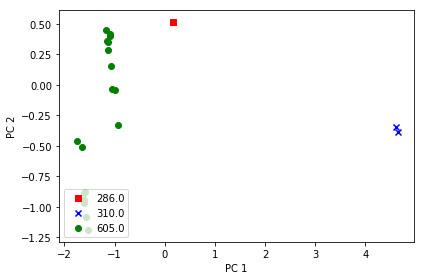

In [241]:
import matplotlib.pyplot as plt

# Using the projection matrix, we can now transform a sample x
# (represented as a 1x13 dimensional row vector) onto the PCA subspace,
# the Principal Components 1 and 2.
# We can also we can transform the entire 124 x 13 dimensional training
# data set onto the two principal components by calculating the dot product

X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [242]:
from sklearn.decomposition import PCA

# Apply PCA. Use training & testing from Standardize
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [243]:
# It indicates the proportion of the dataset's variance that lies
# along the axis of each principal component
print(pca.explained_variance_ratio_)

[0.21590042 0.18782835]


In [245]:
#Changed n_components to 3, seeing if there is a change
# PC1 to PC3 add up to .5350

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21590042 0.18782835 0.131346  ]


In [246]:
# Changed n_components to 7, to add up the ratios
# PC1 to PC7 add up to .9518
# 21.5% of the dataset's variance lies along the first axis,
# 18.7% of the dataset's variance lies along the second axis
# The further down we go with the PC, the less information is
# carried on the axes
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)

[0.21590042 0.18782835 0.131346   0.12931493 0.1076062  0.09689349
 0.08314873]


In [247]:
# Book: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
# by Aurelien Geron 2nd Edition
# pg 225

# You can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance we wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.98592117]


In [248]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Prepare the multilabel classifier "One vs. Rest" with PCA
model_pca = OneVsRestClassifier(SVC(kernel='rbf', degree=2, C=1.0))
model_pca.fit(X_train_pca, y_train)

acct_score2 = accuracy_score(y_test, model_pca.predict(X_test_pca))

print('The accuracy score of multi-label classification with PCA {}.'.format(round(acct_score2, 2)))

The accuracy score of multi-label classification with PCA 0.81.


### Classifiers using kfold cross validation: Standard Decision Tree, Random Forest & Adaboost

In [250]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

# Prepare the models:
# Standard Decision Tree Classifier,
# Random Forest with a depth of 2
# Adaboost Classifier on Standared Decision Tree Classifier
# First Adaptive Boosting aka Adaboost
# Compare them using kfold cross validation with k=10 aka "n_splits=10"

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('Adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.163000 (0.129850)
Random Forest: 0.047000 (0.074169)
Adaboost: 0.160000 (0.129306)


### Comparing algorithms by box plots

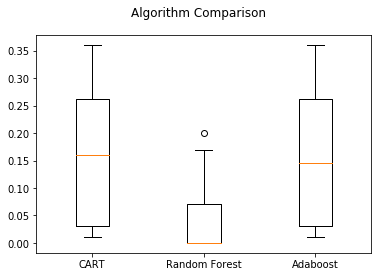

In [251]:
from matplotlib import pyplot

# Comparing algorithms by box plots

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Predictions with Adaboost Classifier (F1-score)

In [252]:
from sklearn.metrics import classification_report, confusion_matrix

# Implement the Adaboost Classifier on Standared Decision Tree Classifier
# Do a fit method to train the system
Adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                              n_estimators=200,
                                              algorithm="SAMME.R",
                                              learning_rate=0.5,
                                              random_state=42)  
Adaboost.fit(X_train, y_train)

# Make predictions using the test set
y_pred = Adaboost.predict(X_test)

# Run the classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 6]]
              precision    recall  f1-score   support

       286.0       1.00      1.00      1.00         1
       310.0       1.00      1.00      1.00         2
       605.0       1.00      1.00      1.00         4
       816.0       0.82      1.00      0.90        14
      1173.0       1.00      1.00      1.00         7
      2156.0       1.00      1.00      1.00         6
      2454.0       1.00      1.00      1.00         4
      5403.0       1.00      1.00      1.00         2
      6990.0       1.00      1.00      1.00         2
      7172.0       1.00      1.00      1.00         2
      7258.0       1.00      1.00      1.00         2
      7691.0       0.89      1.00      0.94         8
     12762.0       1.00      1.00      1.00         5
     14499.0       1.00      1.00      1.00         7
     16111.0       0.50      1.00      0.67         1
     17227.0   

References <br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD.fit_transform<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html<br>
http://jonathansoma.com/lede/foundations/classes/text%20processing/tf-idf/<br>
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py